# Volatility Project by Jakub and Timotej

If you need to install any of those libraries, just uncomment and run the cell below. Those are the ones used in our project.

In [1]:
#!pip install pandas


Importing libraries.

In [533]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns

In [534]:
import DataReader as rd
import importlib
importlib.reload(rd)
warnings.filterwarnings("ignore", category=UserWarning, module="openpyxl")

reader = rd.DataReader()
data = reader.ReadData()


Base path: /Users/jakubmichalski/IES/Volatility-project
Loaded VIX from VIX_History.csv
Loaded SOFR from SOFR.xlsx
Loaded GDP from GDP.xlsx
Loaded GNI from GNI.xlsx
Loaded GNP from GNP.xlsx
Loaded Unemployment from Unemployment.xlsx
Loaded CPI from CPI.xlsx
Loaded PPI from PPI.xlsx


In [535]:
import DataPreprocessor as dp
#potom importlib odstranit
importlib.reload(dp)

dataPreprocessor = dp.DataPreprocessor(data)

'\n"VIX": ("VIX_History.csv", "DATE"),\n                "TenYear": ("10y.xlsx", "Date"),\n                "SOFR": ("SOFR.xlsx", "Effective Date"),\n                "GDP": ("GDP.xlsx", "GDP Final*"),\n                "GNI": ("GNI.xlsx", "Period"),\n                "GNP": ("GNP.xlsx", "Period"),\n                "Unemployment": ("Unemployment.xlsx", "Original Release Date"),\n                "CPI": ("CPI.xlsx", "Original Release Date"),\n                "PPI\n                '

In [536]:
dataset = dataPreprocessor.SetSameInterval()

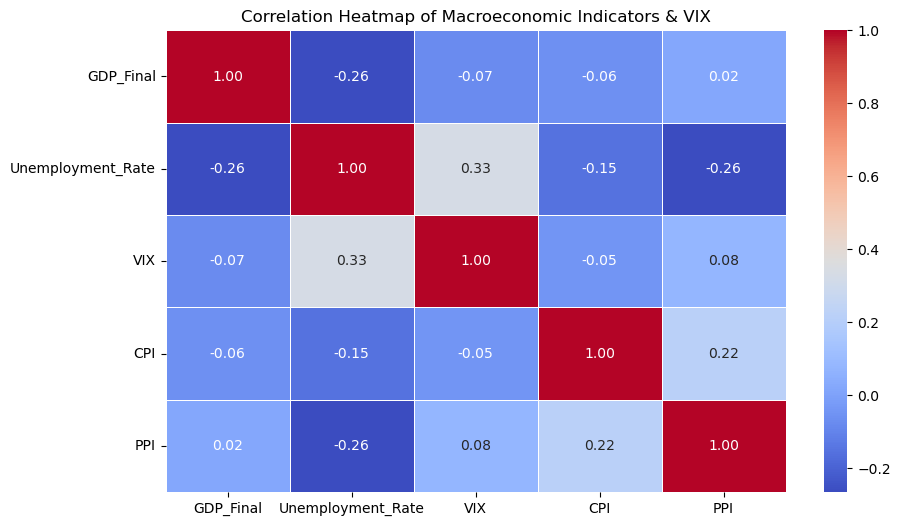

In [537]:
correlation_matrix = dataset.corr()

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Macroeconomic Indicators & VIX")
plt.show()

In [538]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(series):
    """Runs Augmented Dickey-Fuller (ADF) test and prints results."""
    result = adfuller(series.dropna())
    print(f"🔹 {series.name} ADF Test Results:")
    print(f"   ADF Statistic: {result[0]:.3f}")
    print(f"   p-value: {result[1]:.4f}")
    print(f"   Critical Values: {result[4]}")
    if result[1] < 0.05:
        print("   ✅ Stationary (Reject H0)\n")
    else:
        print("   ❌ Non-Stationary (Fail to Reject H0, Consider Differencing)\n")

# Run stationarity test for each variable
for col in dataset.columns:
    check_stationarity(dataset[col])

🔹 GDP_Final ADF Test Results:
   ADF Statistic: -3.072
   p-value: 0.0287
   Critical Values: {'1%': -3.4948504603223145, '5%': -2.889758398668639, '10%': -2.5818220155325444}
   ✅ Stationary (Reject H0)

🔹 Unemployment_Rate ADF Test Results:
   ADF Statistic: -3.277
   p-value: 0.0160
   Critical Values: {'1%': -3.4880216384691867, '5%': -2.8867966864160075, '10%': -2.5802408234244947}
   ✅ Stationary (Reject H0)

🔹 VIX ADF Test Results:
   ADF Statistic: -4.679
   p-value: 0.0001
   Critical Values: {'1%': -3.4880216384691867, '5%': -2.8867966864160075, '10%': -2.5802408234244947}
   ✅ Stationary (Reject H0)

🔹 CPI ADF Test Results:
   ADF Statistic: -2.030
   p-value: 0.2735
   Critical Values: {'1%': -3.4912451337340342, '5%': -2.8881954545454547, '10%': -2.5809876033057852}
   ❌ Non-Stationary (Fail to Reject H0, Consider Differencing)

🔹 PPI ADF Test Results:
   ADF Statistic: -0.552
   p-value: 0.8815
   Critical Values: {'1%': -3.4936021509366793, '5%': -2.8892174239808703, '10

In [539]:
df_diff = dataset.copy()
df_diff["CPI"] = df_diff["CPI"].diff()
df_diff["PPI"] = df_diff["PPI"].diff()

df_diff.dropna(inplace=True)
print("\n🔍 **Rechecking Stationarity After Differencing:**")
for col in df_diff.columns:
    check_stationarity(df_diff[col])



🔍 **Rechecking Stationarity After Differencing:**
🔹 GDP_Final ADF Test Results:
   ADF Statistic: -3.056
   p-value: 0.0300
   Critical Values: {'1%': -3.4954932834550623, '5%': -2.8900369024285117, '10%': -2.5819706975209726}
   ✅ Stationary (Reject H0)

🔹 Unemployment_Rate ADF Test Results:
   ADF Statistic: -3.257
   p-value: 0.0169
   Critical Values: {'1%': -3.4885349695076844, '5%': -2.887019521656941, '10%': -2.5803597920604915}
   ✅ Stationary (Reject H0)

🔹 VIX ADF Test Results:
   ADF Statistic: -4.648
   p-value: 0.0001
   Critical Values: {'1%': -3.4885349695076844, '5%': -2.887019521656941, '10%': -2.5803597920604915}
   ✅ Stationary (Reject H0)

🔹 CPI ADF Test Results:
   ADF Statistic: -8.176
   p-value: 0.0000
   Critical Values: {'1%': -3.4912451337340342, '5%': -2.8881954545454547, '10%': -2.5809876033057852}
   ✅ Stationary (Reject H0)

🔹 PPI ADF Test Results:
   ADF Statistic: -2.624
   p-value: 0.0881
   Critical Values: {'1%': -3.4961490537199116, '5%': -2.890320


🔍 **Explained Variance by Principal Components:**
PC1: 0.3677 (36.77% of variance)
PC2: 0.2815 (28.15% of variance)
PC3: 0.1924 (19.24% of variance)
PC4: 0.1584 (15.84% of variance)


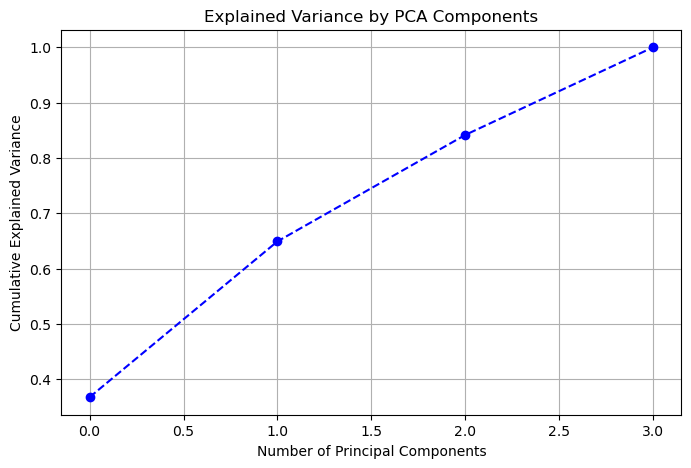

In [541]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
macro_features = ["GDP_Final", "Unemployment_Rate", "CPI", "PPI"]
scaler = StandardScaler()
df_scaled = scaler.fit_transform(dataset[macro_features])
pca = PCA(n_components=len(macro_features))
principal_components = pca.fit_transform(df_scaled)
explained_variance = pca.explained_variance_ratio_
print("\n🔍 **Explained Variance by Principal Components:**")
for i, var in enumerate(explained_variance):
    print(f"PC{i+1}: {var:.4f} ({var * 100:.2f}% of variance)")
plt.figure(figsize=(8,5))
plt.plot(np.cumsum(explained_variance), marker='o', linestyle='--', color='b')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by PCA Components')
plt.grid()
plt.show()



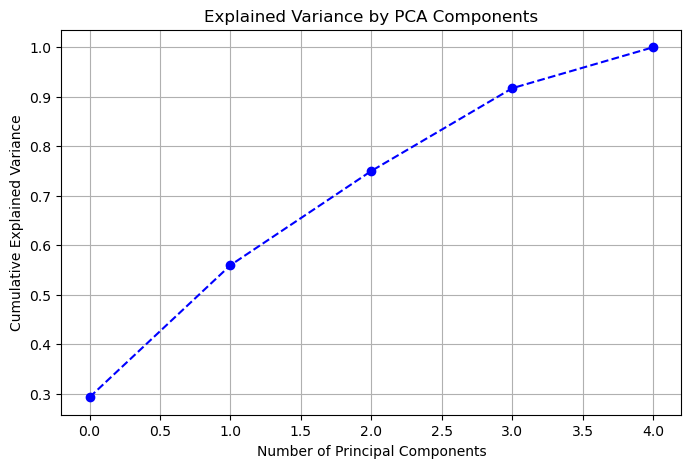

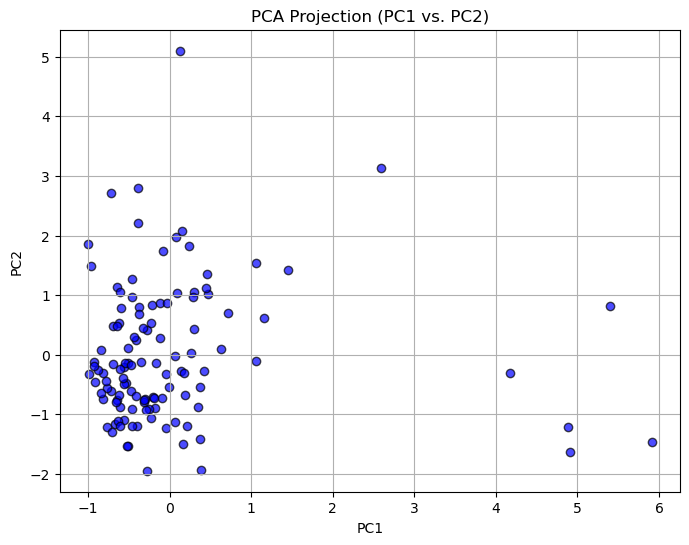